In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
#  Chemin vers le CSV
csv_path = "C:\\Users\\meddh\\Trendify\\Data\\social_media_viral_content_dataset.csv"
#  Charger le dataset
df = pd.read_csv(csv_path)
print("Dimensions du dataset :", df.shape)
df.head()

#  Aperçu des données
print(df.info())
print(df.describe())

Dimensions du dataset : (2000, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   post_id          2000 non-null   object 
 1   platform         2000 non-null   object 
 2   content_type     2000 non-null   object 
 3   topic            2000 non-null   object 
 4   language         2000 non-null   object 
 5   region           2000 non-null   object 
 6   post_datetime    2000 non-null   object 
 7   hashtags         2000 non-null   object 
 8   views            2000 non-null   int64  
 9   likes            2000 non-null   int64  
 10  comments         2000 non-null   int64  
 11  shares           2000 non-null   int64  
 12  engagement_rate  2000 non-null   float64
 13  sentiment_score  2000 non-null   float64
 14  is_viral         2000 non-null   int64  
dtypes: float64(2), int64(5), object(8)
memory usage: 234.5+ KB
None
       

In [4]:
#  Pré-traitement des données
df.drop(columns=["post_id", "hashtags"], inplace=True)
df["post_datetime"] = pd.to_datetime(df["post_datetime"])

df["post_hour"] = df["post_datetime"].dt.hour
df["post_day"] = df["post_datetime"].dt.day
df["post_month"] = df["post_datetime"].dt.month

df.drop(columns=["post_datetime"], inplace=True)
#Encoder les variables catégorielles
cat_cols = df.select_dtypes(include="object").columns

le = LabelEncoder()
for col in cat_cols:
    df[col] = le.fit_transform(df[col])



In [5]:
# Définition de X et y (CORRECTION DE L’ERREUR)
# Colonne cible CORRECTE
target_column = "is_viral"

X = df.drop(columns=[target_column])
y = df[target_column]


In [6]:
# Normalisation (indispensable pour KNN)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)



In [7]:
# Entraînement du modèle KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
# Évaluation
print("Accuracy :", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))




Accuracy : 0.845

Classification Report:

              precision    recall  f1-score   support

           0       0.77      0.69      0.73       120
           1       0.87      0.91      0.89       280

    accuracy                           0.84       400
   macro avg       0.82      0.80      0.81       400
weighted avg       0.84      0.84      0.84       400



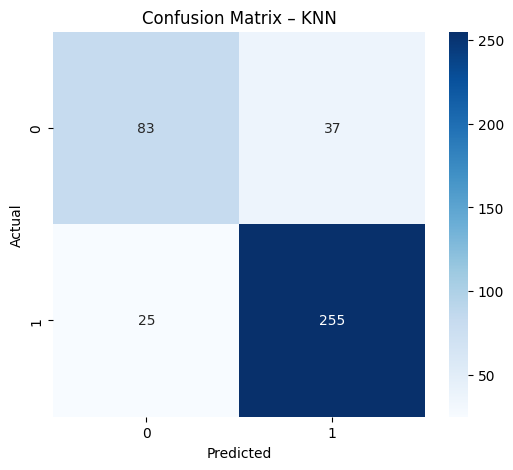

In [8]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix – KNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [9]:
from sklearn.model_selection import GridSearchCV


In [10]:
# On teste plusieurs valeurs de k (impair pour éviter les égalités)
param_grid = {
    "n_neighbors": list(range(1, 31, 2)),  # 1,3,5,...,29
    "weights": ["uniform", "distance"],
    "metric": ["euclidean", "manhattan"]
}


In [11]:
# Lancer GridSearchCV
knn = KNeighborsClassifier()

grid = GridSearchCV(
    knn,
    param_grid,
    cv=5,                # validation croisée
    scoring="accuracy",  # critère d’optimisation
    n_jobs=-1            # utilise tous les cœurs
)

grid.fit(X_train, y_train)


,estimator,KNeighborsClassifier()
,param_grid,"{'metric': ['euclidean', 'manhattan'], 'n_neighbors': [1, 3, ...], 'weights': ['uniform', 'distance']}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,n_neighbors,19


In [12]:
print("Meilleurs paramètres :", grid.best_params_)
print("Meilleure accuracy (CV) :", grid.best_score_)


Meilleurs paramètres : {'metric': 'manhattan', 'n_neighbors': 19, 'weights': 'distance'}
Meilleure accuracy (CV) : 0.9268749999999999


In [13]:
best_knn = grid.best_estimator_

y_pred_best = best_knn.predict(X_test)

print("Accuracy sur test :", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))


Accuracy sur test : 0.92
              precision    recall  f1-score   support

           0       0.93      0.79      0.86       120
           1       0.92      0.97      0.94       280

    accuracy                           0.92       400
   macro avg       0.92      0.88      0.90       400
weighted avg       0.92      0.92      0.92       400



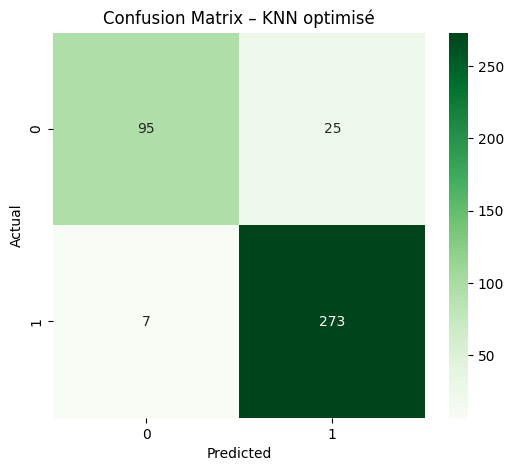

In [14]:
cm = confusion_matrix(y_test, y_pred_best)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix – KNN optimisé")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


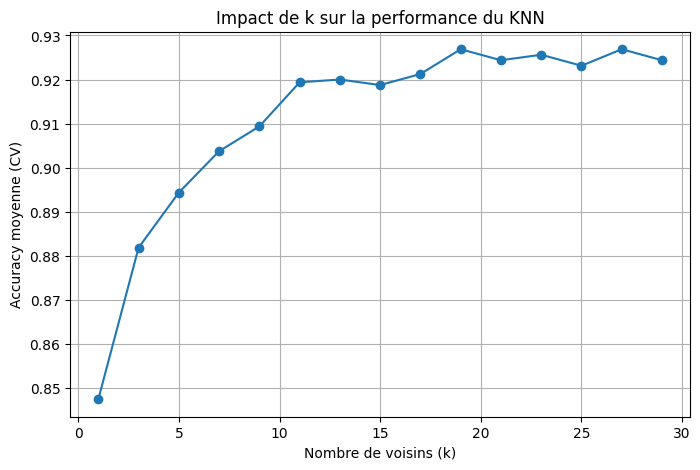

In [15]:

# Visualiser l’accuracy en fonction de k
results = pd.DataFrame(grid.cv_results_)

k_scores = results.groupby("param_n_neighbors")["mean_test_score"].max()

plt.figure(figsize=(8,5))
plt.plot(k_scores.index, k_scores.values, marker='o')
plt.xlabel("Nombre de voisins (k)")
plt.ylabel("Accuracy moyenne (CV)")
plt.title("Impact de k sur la performance du KNN")
plt.grid(True)
plt.show()


In [16]:
#Vérification simple d'overfitting : Accuracy train vs test
# Accuracy sur le jeu d'entraînement
y_train_pred = best_knn.predict(X_train)
train_acc = accuracy_score(y_train, y_train_pred)

# Accuracy sur le jeu de test
y_test_pred = best_knn.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
#Si train_acc >> test_acc → overfitting
#Si train_acc ≈ test_acc → bon ajustement
print(f"Accuracy Train : {train_acc:.4f}")
print(f"Accuracy Test  : {test_acc:.4f}")


Accuracy Train : 1.0000
Accuracy Test  : 0.9200


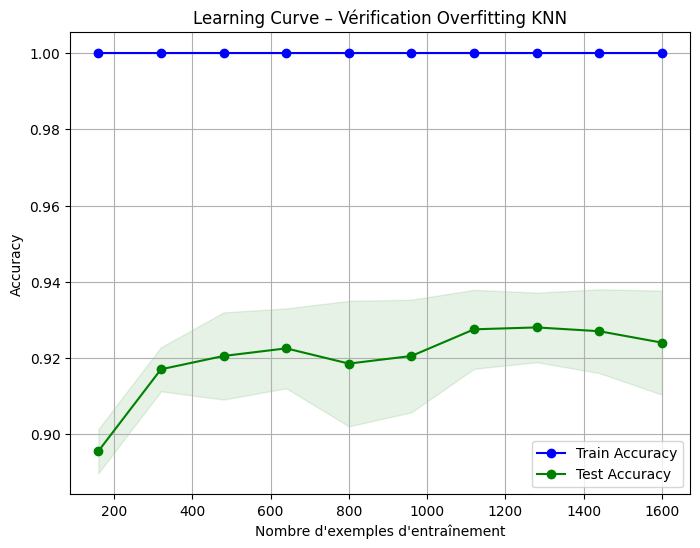

In [17]:
#Option avancée : Graphique Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_knn, X_scaled, y, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1,1.0,10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, 'o-', color='blue', label='Train Accuracy')
plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.1, color='blue')
plt.plot(train_sizes, test_mean, 'o-', color='green', label='Test Accuracy')
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.1, color='green')
plt.xlabel('Nombre d\'exemples d\'entraînement')
plt.ylabel('Accuracy')
plt.title('Learning Curve – Vérification Overfitting KNN')
plt.legend()
plt.grid(True)
plt.show()


**DummyClassifier**

> DummyClassifier est un modèle très simple qui ne regarde pas les données pour faire ses prédictions.
Il sert à créer une baseline, c’est-à-dire un score minimum de référence.



=== Dummy Classifier ===
Accuracy : 0.7

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       120
           1       0.70      1.00      0.82       280

    accuracy                           0.70       400
   macro avg       0.35      0.50      0.41       400
weighted avg       0.49      0.70      0.58       400



c:\Users\meddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\meddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\meddh\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

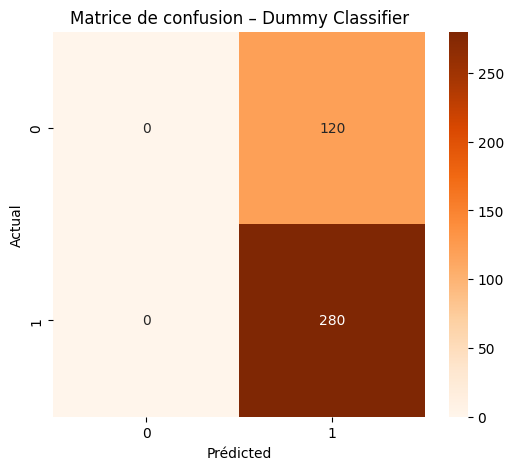

In [18]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# ------------------------------
# Définir le DummyClassifier
# ------------------------------
dummy = DummyClassifier(strategy="most_frequent")  # prédiction de la classe majoritaire
dummy.fit(X_train, y_train)

# ------------------------------
# Prédictions
# ------------------------------
y_dummy_pred = dummy.predict(X_test)

# ------------------------------
# Évaluation
# ------------------------------
print("=== Dummy Classifier ===")
print("Accuracy :", accuracy_score(y_test, y_dummy_pred))
print("\nClassification Report:\n", classification_report(y_test, y_dummy_pred))

# Matrice de confusion
cm_dummy = confusion_matrix(y_test, y_dummy_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm_dummy, annot=True, fmt="d", cmap="Oranges")
plt.title("Matrice de confusion – Dummy Classifier")
plt.xlabel("Prédicted")
plt.ylabel("Actual")
plt.show()


In [22]:
import pickle
from pathlib import Path
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

MODELS_DIR = Path("../../models/trained")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

knn_pipeline = make_pipeline(StandardScaler(), best_knn)
knn_pipeline.fit(X, y)

with open(MODELS_DIR / "knn.pkl", "wb") as f:
    pickle.dump(knn_pipeline, f)

print("Saved model to:", MODELS_DIR / "knn.pkl")

Saved model to: ..\..\models\trained\knn.pkl
